In [1]:
def GetArticlesFromDateRange(startDate, endDate, dateToCheck):
    castedDateToCheck = datetime.datetime.strptime(dateToCheck, '%Y-%m-%d').date()
    if castedDateToCheck >= startDate and castedDateToCheck < endDate:
        return True
    
    return False

In [2]:
class article(object):
    def __init__(self, date, information):
        self.Date = date
        self.Information = information

# Got the medical documents from:
https://github.com/socd06/medical-nlp <br />
There's another tool someone made to get all medical terminologies on that link

In [3]:
def GetMedicalTerms(filePath): 
    
    lines = []
    with open(filePath) as f:
        for line in f:
            lines.append(line.strip().lower())
            
    return lines

# Initializing the LDA Model
https://radimrehurek.com/gensim/models/ldaseqmodel.html

In [4]:
from gensim.models import LdaSeqModel

def GetTopicModel(corpus, id2word,dictionary, numberOfTopics = 10, chunkSize=2000):

    temp = dictionary[0]  
    
    return LdaSeqModel(corpus=corpus,
                       time_slice=[2330, 5992, 9234],#,9486,8986,8470,9178,9325,8368,7284,8857,5059],
                       num_topics=numberOfTopics,
                       id2word=id2word,
                       chunksize=chunkSize)

# Get the rule associations

In [5]:
from apyori import apriori
from nltk.stem import WordNetLemmatizer, PorterStemmer
from datetime import datetime
import pandas as pd  
from IPython.display import HTML 

def PrintRuleAssociation(support, confidence, bow, listOfDocs, lift, length = None):   
    porter = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    if len(bow) == 0:
        print('No topics found')
        return
    
    rules = apriori(bow,
                    min_support= support,
                    min_confidence= confidence,
                    min_lift= lift,
                    max_length= length)
    
    results = list(rules)
    
    df = pd.DataFrame(columns=('Left Hand Side',
                               'Right Hand Side',
                               'Support',
                               'Confidence',
                               'Lift',
                               'Count'))
    
    Support =[]
    Confidence = []
    Lift = []
    Items = []
    Antecedent = []
    Consequent=[]
    Count = []
    tfidf = []
      
    maxCount = 0
    tfidfAverage = 0
    
    for RelationRecord in results:
        for ordered_stat in RelationRecord.ordered_statistics:
            #print("count:", len(ordered_stat.items_base) + len(ordered_stat.items_add))
            #print("cons:", ordered_stat.items_add)
            if IsAntecedentDifferentFromConsequent(ordered_stat.items_base, ordered_stat.items_add):
                if maxCount < len(ordered_stat.items_base) + len(ordered_stat.items_add):
                    maxCount = len(ordered_stat.items_base) + len(ordered_stat.items_add)
                    
                consequences = list(ordered_stat.items_base)
                antecedent = list(ordered_stat.items_add)
                Support.append(RelationRecord.support)
                Antecedent.append(ordered_stat.items_base)
                Consequent.append(ordered_stat.items_add)
                Confidence.append(ordered_stat.confidence)
                Lift.append(ordered_stat.lift)
                Count.append(len(ordered_stat.items_base) + len(ordered_stat.items_add))
                tfidfsum = 0
                for c in consequences:
                    tfidfsum += GetWordTFIDFMeasure(c, docsAsString)
                    
                for a in antecedent:
                    tfidfsum += GetWordTFIDFMeasure(a, docsAsString)
                
                tfidfAverage =  tfidfsum/maxCount
                
    df['Left Hand Side'] = list(map(set, Antecedent))
    df['Right Hand Side'] = list(map(set, Consequent))
    df['Support'] = Support
    df['Confidence'] = Confidence
    df['Lift'] = Lift
    df['Count'] = Count
    df['TF-IDF Average'] = tfidfAverage
    
    df.sort_values(by ='Lift', ascending = False, inplace = True)
            
    display(HTML(df.to_html()))

In [6]:
from nltk.stem import LancasterStemmer

def SameStem(word1, word2, printStemmedWords = False):
    lancaster = LancasterStemmer()
    if printStemmedWords:
        print(lancaster.stem(word1), lancaster.stem(word2))

    return lancaster.stem(word1) == lancaster.stem(word2)

In [7]:
def IsAntecedentDifferentFromConsequent(Antecedent, Consequent):
    for ant in Antecedent:
        for cons in Consequent:
            if SameStem(ant, cons):
                return False
        
    return True
    

# Create the ngrams and set the ngram thresholds
min_count – Ignore all words and bigrams with total collected count lower than this value.
threshold – Represent a score threshold for forming the phrases. A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.


In [8]:
import gensim
from gensim.models.phrases import Phrases,Phraser

def ngrams(words, minimumCount=5, threshold=15):
    bigram = Phrases(words,
                     min_count=minimumCount,
                     threshold=threshold)
    
    trigram = Phrases(bigram[words],
                      threshold=threshold)  

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_mod, trigram_mod


# TF-IDF WORD CHECK
Gets the TF-IDF value for a single word

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer 
import numpy as np

def GetWordTFIDFMeasure(wordToFind, docsAsString):

    tfidf_vectorizer=TfidfVectorizer(use_idf=True)
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docsAsString)

    tfidf = tfidf_vectorizer_vectors.todense()

    tfidf[tfidf == 0] = np.nan

    means = np.nanmean(tfidf, axis=0)

    means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))

    tfidf = tfidf_vectorizer_vectors.todense()

    ordered = np.argsort(tfidf*-1)
    words = tfidf_vectorizer.get_feature_names()

    for i, doc in enumerate(docsAsString):
        result = { }
        for t in range(len(doc)):
            if(words[ordered[i,t]] == wordToFind):
                return means[words[ordered[i,t]]]

# KMEANS CLUSTERING
https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

In [25]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

def GetTopicsUsingTFIDFAndKMeansClustering(data, numberOfClusters, topNumberOfTerms):
    tfidf = TfidfVectorizer(use_idf=True)
    tfidf.fit(data)
    text = tfidf.transform(data)
    clusters = MiniBatchKMeans(n_clusters=10).fit_predict(text)
    
    df = pd.DataFrame(text.todense()).groupby(clusters).mean()

    labels = tfidf.get_feature_names()
    
    results = []
    for i,r in df.iterrows():
        topic = [labels[t] for t in np.argsort(r)[-topNumberOfTerms:]]
        
        #results.append(','.join([labels[t] for t in np.argsort(r)[-topNumberOfTerms:]]))
    
        results.append(topic)
    
    return results
    
    

# Get the qualifying articles from the metadata
1. Qualifies if the publication date is within a given date range 
2. Has a pmc jcon file associated

In [11]:
from collections import defaultdict
import csv
from pathlib import Path
import json
import os.path

def GetData(startDate, endDate, path):
    listofarticles = []
    try:
        with open(path + 'metadata.csv') as f_in:
            reader = csv.DictReader(f_in)
            for row in reader:
                if '-' not in row['publish_time']:
                    continue
                elif startDate > datetime.datetime.strptime(row['publish_time'], '%Y-%m-%d').date() or datetime.datetime.strptime(row['publish_time'], '%Y-%m-%d').date() > endDate:
                    continue
                if not row['pmc_json_files']:
                    continue 
            
                for json_path in row['pmc_json_files'].split(';'):
                    listofarticles.append(article(row['publish_time'], json_path))
                
    except ValueError:
        print("An error occurred: ", ValueError, " Please try again.")
    return listofarticles

# Get the textbodies from the list of pdfs
1. Remove all special characters

In [12]:
import json
import re

def GetTextBodies(listOfpdfs, path):    
    text = []    
    
    medicalWords = GetMedicalTerms("vocab.txt")

    for pdf in listOfpdfs:
        filePath = path + pdf.Information.replace(" ", "")

        if not os.path.exists(filePath):
            continue
        
        with open(filePath) as f_json:
            full_text_dict = json.load(f_json)
            textBody = []
            for paragraph_dict in full_text_dict['body_text']:          
                paragraph_text = re.sub(r'[^a-zA-Z_\s]+', '', paragraph_dict['text'])   
                paragraph_text = paragraph_text.lower()
                
                pdf.Information = paragraph_text
    return listOfpdfs

# Do the data pre-processing
1. remove stop words
2. lower case all words
3. Check to see if the word is within the list of medical terms given

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize  
from nltk.stem import WordNetLemmatizer, PorterStemmer

def CleanTheData(listOfDocs): 
    porter = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    stop_words = set(stopwords.words('english'))
  
    resultDocs = []
    words = set(nltk.corpus.words.words())
    medicalWords = GetMedicalTerms("vocab.txt")
    medicalStopWords = GetMedicalTerms("clinical-stopwords.txt")
    
    for doc in listOfDocs:
        result = []
        for word in doc.Information.split(' '):  
            
            if word in "" or len(word) <= 3 or word in stop_words or word not in medicalWords or word in medicalStopWords:
                continue
                
            result.append(word)
                
        doc.Information = result
    return listOfDocs

# Create the corpus
1. Create the dictionary with all words and word ids
2. Create the bi,tri, and quadgrams if applicable
3. remove extreme occurences of words

In [14]:
from gensim.corpora.dictionary import Dictionary

def ConvertDataToCorpus(cleaned_data):

    dictionary = Dictionary(cleaned_data)
    bigramMod, trigramMod = ngrams(cleaned_data)
    
    ngram =  [trigramMod[bigramMod[review]] for review in cleaned_data]
       
    id2word = gensim.corpora.Dictionary(ngram)
    id2word.filter_extremes(no_below=10, no_above=0.90, keep_tokens=['covid', 'coronavirus','sarscov'])
    
    id2word.compactify()
    
    corpus = [id2word.doc2bow(text) for text in ngram]
    
    return corpus, id2word, dictionary

# Get all the topics from the dynamic topic model
1. Print the top 20 words

In [15]:
def GetAllTopicsFromModel(dtm):
    topics = dtm.print_topics(3)
    #print(topics)
    
    for topic in topics:
        print("word:", topic[0]);

# Get all qualifying topics generated from LDA model
1. Get all topics from the LDA model
2. Per each topic, check to see if the coherence score is greater than the lower bounce given
3. Per word, check to see if the word or a related word exists in the current topic, if it does, do not add
4. Per word, check to see if the probablity that the word is in the current topic is greater than the lower bound given
5. Do not consider topics with only one qualifying word

Notes: can read about coherence scores here: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad 
https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf


In [16]:
import datetime
def GetInformation(minProbablity, startDate, endDate, path):
    
    print('Starting', datetime.datetime.now())
    listOfpdfs= GetData(startDate, endDate,path)
    
    if len(listOfpdfs) == 0:
        print("No PDFs found under this topic")
        exit
        
    print(len(listOfpdfs))
    
    print('Finished gathering data', datetime.datetime.now())
    data = GetTextBodies(listOfpdfs, path)
    data.sort(key=lambda x: x.Date, reverse=False)
    print('Finished sorting data', datetime.datetime.now())
    cleaned_data = CleanTheData(data)  
    print('Finished cleaning data', datetime.datetime.now())  

    justDoc = []
    for datum in cleaned_data:
        justDoc.append(datum.Information)
        
        
    
    corpus, id2word, dictionary = ConvertDataToCorpus(justDoc) 
    print('Finished converting data to corpus', datetime.datetime.now())  
    
    dtm = GetTopicModel(corpus,
                      id2word, 
                      dictionary,
                      numberOfTopics = 50,
                      chunkSize=2000)  
    print('Finished creating LDA model', datetime.datetime.now())  
    
    GetAllTopicsFromModel(dtm)
    
#    topics = GetTopicTerms(searchTerm,
#                           lda = lda, 
#                           id2word = id2word,
#                           cleaned_data=cleaned_data, 
#                           lowerEndCoherenceScore=0, 
#                           numberOfWords=30, 
#                           minimumprobablity= minProbablity,
#                           windowSize= 15,
#                           processes=10)
    
    print('Finished creating DTM model', datetime.datetime.now())  
    
 #   PrintRuleAssociation(lda, 
 #                        support=0.1,
 #                        confidence=0.8,
 #                        bow=topics, 
 #                        lift = 1, 
 #                        length = None)
 #   print('Finished', datetime.datetime.now()) 



In [17]:
def PrintTopicsInTimeSlice(index, dtm, docsAsString):
    dtmResults = dtm.print_topics(index,top_terms=10)  

    dtmJustTheWords = []

    for r in dtmResults:
        words = {}
        av = 0
        for word in r:
            #print(word)
            if "_" in word[0]:
                continue
            
            tfidf = GetWordTFIDFMeasure(word[0], docsAsString)
            print(word[0], tfidf)
            if tfidf is None:
                continue
            av += tfidf
        print('average TF-IDF: ', av/10)
        print('\n')

In [18]:
def GetRulesFromTFIDFClusters(start, end, cleaned_data):

    docsAsString = []

    for datum in cleaned_data:
        if GetArticlesFromDateRange(start,end, datum.Date):
            docsAsString.append(' '.join(str(info) for info in datum.Information))
                
    t = GetTopicsUsingTFIDFAndKMeansClustering(docsAsString, 20,10)
    PrintRuleAssociation(support=0.175,
                         confidence=0.9,
                         bow=t, 
                         listOfDocs = docsAsString,
                         lift = 1, 
                         length = None)

#first month = 2330
#second month = 5992
#third month = 9234
#fourth month = 9486
#fifth =  8986
#sixth = 8470
#7th = 9178
#8th = 9325
#9th = 8368
#10th = 7284
#11th = 8857
#12th = 5059
#Finished gathering data 2021-03-16 21:17:36.279353

#Finished gathering data 2021-03-16 21:17:52.412954
#Finished gathering data 2021-03-16 21:20:53.203475


with stop word filter:
Finished gathering data 2021-03-16 21:55:08.355088
88349
Finished gathering data 2021-03-16 21:55:24.637484
Finished gathering data 2021-03-16 21:58:17.915549
Finished cleaning data 2021-03-16 22:31:32.614923

In [68]:
startDate = datetime.date(2021, 1, 1)
endDate = datetime.date(2021, 2, 1)
path = '/Users/jessicaosekowsky/Downloads/2021-05-31/'

print('Starting', datetime.datetime.now())
listOfpdfs= GetData(startDate, endDate,path)
    
if len(listOfpdfs) == 0:
    print("No PDFs found under this topic")
    exit
        
print(len(listOfpdfs))
    
print('Finished gathering data', datetime.datetime.now())


Starting 2021-06-06 19:39:58.634498
2351
Finished gathering data 2021-06-06 19:40:22.348383


In [69]:
print('Finished sorting data', datetime.datetime.now())
data = GetTextBodies(listOfpdfs, path)
data.sort(key=lambda x: x.Date, reverse=True)
print('Finished sorting data', datetime.datetime.now())
print(data[0])

Finished sorting data 2021-06-06 19:40:22.356110
Finished sorting data 2021-06-06 19:40:29.364120


In [70]:
print('Finished cleaning data', datetime.datetime.now()) 
#cleaned_data = CleanTheData(data)  
print('Finished cleaning data', datetime.datetime.now())  

Finished cleaning data 2021-06-06 19:40:29.371541


KeyboardInterrupt: 

In [73]:

print(data[2])


print('Finished converting data to corpus', datetime.datetime.now())  
justDoc = []
docsAsString = []
for datum in cleaned_data:
    justDoc.append(datum.Information)
    doc = ''
    for info in datum.Information:
        doc += info
        doc += ' '
        
    justDoc.append(doc)
    
    
    docsAsString.append(' '.join(datum.Information))
          
    
#corpus, id2word, dictionary = ConvertDataToCorpus(justDoc) 
print('Finished converting data to corpus', datetime.datetime.now())  
print(justDoc[2])
    

Finished converting data to corpus 2021-06-06 19:41:53.172143
Finished converting data to corpus 2021-06-06 19:41:53.362207
['original', 'investigation', 'characteristics', 'results', 'semen', 'tests', 'coronavirus', 'section', 'specify', 'method', 'severe', 'acute', 'respiratory', 'syndrome', 'coronavirus', 'semen', 'method', 'reverse', 'chain', 'assay', 'corrected']


In [8]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(use_idf=True)
tfidf.fit(justDoc)
text = tfidf.transform(justDoc)
clusters = MiniBatchKMeans(n_clusters=10).fit_predict(text)
    
df = pd.DataFrame(text.todense()).groupby(clusters).mean()

#label = tfidf.get_feature_names()

label = MiniBatchKMeans.fit_predict(df)
    
print(label)
 #   results = []
 #   for i,r in df.iterrows():
 #       topic = [labels[t] for t in np.argsort(r)[-topNumberOfTerms:]]
        
        #results.append(','.join([labels[t] for t in np.argsort(r)[-topNumberOfTerms:]]))
    
 #       results.append(topic)
    
 #   return results
    
 
    #filter rows of original data
filtered_label0 = df[label == 1]
 
    #plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

NameError: name 'justDoc' is not defined

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [48]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = data#fetch_20newsgroups(subset='all', categories=categories,

t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


AttributeError: 'article' object has no attribute 'lower'

In [ ]:
#pip install -U gensim

In [ ]:
#pip install python-Levenshtein

In [ ]:
#pip install apyori

In [ ]:
#import nltk
#nltk.download()

In [9]:
import csv
import os
import json
from collections import defaultdict

cord_uid_to_text = defaultdict(list)

# open the file


counter = 0
with open('metadata.csv') as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
        if counter > 20:
            break
        # access some metadata
        cord_uid = row['cord_uid']
        title = row['title']
        abstract = row['abstract']
        authors = row['authors'].split('; ')

        # access the full text (if available) for Intro
        introduction = []
        if row['pdf_json_files']:
            for json_path in row['pdf_json_files'].split('; '):
                with open(json_path) as f_json:
                    full_text_dict = json.load(f_json)
                    
                    # grab introduction section from *some* version of the full text
                    for paragraph_dict in full_text_dict['body_text']:
                        paragraph_text = paragraph_dict['text']
                        section_name = paragraph_dict['section']
                        if 'intro' in section_name.lower():
                            introduction.append(paragraph_text)

                    # stop searching other copies of full text if already got introduction
                    if introduction:
                        break
        counter = counter + 1

        # save for later usage
        cord_uid_to_text[cord_uid].append(introduction)

In [28]:

import re
newlistOfDocus = []
for key, value in cord_uid_to_text.items():
    doc = ''
    for v in value:
        for m in v:
            print(v[0])
            doc += re.sub(r'[^a-zA-Z_\s]+', '', m)
    newlistOfDocus.append(doc)

Mycoplasma pneumoniae is a common cause of upper and lower respiratory tract infections. It remains one of the most frequent causes of atypical pneumonia particu-larly among young adults. [1, 2, 3, 4, 5] Although it is highly transmissible, most infections caused by this organism are relatively minor and include pharyngitis, tracheobronchitis, bronchiolitis, and croup with one fifth of in-fections being asymptomatic. [6, 7] Only 3 -10% of infected subjects develop symptoms consistent with bronchopneumonia and mortality from infection is rare. [6, 7] The organism is fastidious and difficult to grow on cultures. Therefore, diagnosis of infections caused by this organism is usually confirmed with serological tests or polymerase chain reaction-gene amplification techniques. At King Abdulaziz University Hospital (KAUH), Jeddah, Saudi Arabia, the facility to perform Mycoplasma culture has been available since January 1997. As published information concerning M. pneumoniae infections in Saudi

In [29]:
GetTopicsUsingTFIDFAndKMeansClustering(newlistOfDocus, 10, 20)

[['ap',
  'hypoxia',
  'cytoprotective',
  'may',
  'studies',
  'by',
  'effects',
  'induction',
  'oxidative',
  'to',
  'co',
  'hoco',
  'have',
  'stress',
  'heme',
  'and',
  'in',
  'of',
  'the',
  'ho'],
 ['nitrogen',
  'biological',
  'including',
  'production',
  'as',
  'or',
  'inflammatory',
  'cells',
  'respiratory',
  'proinflammatory',
  'rns',
  'to',
  'such',
  'in',
  'is',
  'no',
  'the',
  'and',
  'of',
  'nos'],
 ['membrane',
  'sanderson',
  'ar',
  'iev',
  'polyamines',
  'during',
  'odc',
  'cell',
  'virus',
  'frameshifting',
  'is',
  'to',
  'vaccinia',
  'in',
  'antizyme',
  'and',
  'of',
  'et',
  'the',
  'al'],
 ['or',
  'for',
  'as',
  'hsv',
  'pli',
  'that',
  'may',
  'uba',
  'transfusions',
  'proteins',
  'ill',
  'critically',
  'ubiquitin',
  'patients',
  'is',
  'and',
  'to',
  'in',
  'of',
  'the'],
 ['was',
  'using',
  'for',
  'subsequent',
  'domains',
  'and',
  'of',
  'similarity',
  'could',
  'threshold',
  'to',
  '

ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 1.

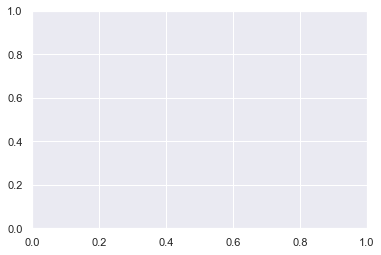

In [38]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
import numpy as np

tfidf = TfidfVectorizer(use_idf=True)
tfidf.fit(newlistOfDocus)
text = tfidf.transform(newlistOfDocus)
clusters = MiniBatchKMeans(n_clusters=10).fit_predict(text)
    
df = pd.DataFrame(text.todense()).groupby(clusters).mean()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

plt.scatter(text[:, 0], text[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.5);